# Tokenization

The tokenizer takes into account a lot of Linguistic Observations.
Ex: Things like possisive markers, EOFs etc etc have been taken into account

In [49]:
import sys, re, collections
import os
import matplotlib.pyplot as plt
import pprint as pp
import numpy as np
from operator import eq

In [50]:
import sys, re, collections
import os

class DataTokenizer():
    def __init__(self, path):
        self.path = path
        if sys.version_info >= (3,3): # Fix this issue.
            self.dashes = ["–", "--+"]
            for i in range(8208, 8214):
                self.dashes.append(chr(i))
        else:
            self.dashes = [u"–", u"--+"]
            for i in range(8208, 8214):
                self.dashes.append(unichr(i))

        self.dashes_no_repeats = self.dashes[:]
        self.dashes_no_repeats.remove("--+")

        self.matching_dashes = self.dashes_no_repeats + ["-+"]

        if sys.version_info >= (3,3):
            self.repeated_dash_converter = re.compile("--+")
            self.dash_converter = re.compile("|".join(self.dashes_no_repeats))
        else:
            self.repeated_dash_converter = re.compile(u"--+")
            self.dash_converter = re.compile(u"|".join(self.dashes_no_repeats))

        # Various tokenization patterns to be used
        self.word_with_alpha_and_period   = re.compile("^([^\.]+)(\.\s*)$")
        self.matching_dashes = self.dashes_no_repeats + ["-+"]
        self.simple_dash_finder           = re.compile("(-\s*)")
        self.advanced_dash_finder         = re.compile("(" + "|".join(self.matching_dashes) + ")\s*")
        self.multi_single_quote_finder    = re.compile("('{2,})\s*")
        self.url_file_finder              = re.compile("(?:[-a-zA-Z0-9@%._\+~#=]{2,256}://)?"
                                                  "(?:www\.)?[-a-zA-Z0-9@:%\._\+~#=]{2,"
                                                  "256}\.[a-z]{2,6}[-a-zA-Z0-9@:%_\+.~#"
                                                  "?&//=]*\s*")
        self.numerical_expression         = re.compile(u"(\d+(?:,\d+)*(?:\.\d+)*(?![a-zA-ZÀ-ż])\s*)")
        self.remaining_quote_converter    = re.compile(u'(.)(?=["“”»])')
        self.shifted_ellipses             = re.compile("([\.\!\?¿¡]{2,})\s*")
        self.shifted_standard_punctuation = re.compile(u"([\(\[\{\}\]\)\!¡\?¿#\$%;~&+=<>|/:,—…])\s*")
        self.pure_whitespace              = re.compile("\s+")
        self.english_specific_appendages = re.compile(u"(\w)(?=['’]([dms])\\b)", re.UNICODE)
        self.english_nots = re.compile(u"(.)(?=n['’]t\\b)", re.UNICODE)
        self.english_contractions = re.compile(u"(.)(?=['’](ve|ll|re)\\b)")
        self.french_appendages = re.compile(u"(\\b[tjnlsmdclTJNLSMLDC]|qu)['’](?=[^tdms])")
        self.word_with_period = re.compile("[^\s\.]+\.{0,1}")
        self.one_letter_long_or_repeating = re.compile("^(?:(?:[a-z])|(?:[a-z](?:\.[a-z])+))$", re.IGNORECASE)
        self.no_punctuation               = re.compile("^\w+$")
        self.left_quote_shifter           = re.compile(u"((`‘(?!`))|(‘(?!‘))\s*)(?=.*\w)", re.UNICODE)
        self.left_quote_converter         = re.compile(u'([«"“]\s*)(?=.*\w)', re.UNICODE)
        self.left_single_quote_converter  = re.compile(u"(?:(\W|^))('\s*)(?=.*\w)", re.UNICODE)
        self.right_single_quote_converter = re.compile(u"(['’]+)(?=\W|$)\s*", re.UNICODE)
        self.UNDECIDED = 0
        self.SHOULD_SPLIT = 1
        self.SHOULD_NOT_SPLIT = 2
        self.PUNCT_SYMBOLS = {'.', "...", "?", "!", "..", "!!", "??", "!?", "?!", u"…"}
        self.MONTHS = {
            "january", "february", "march", "april", "may",
            "june", "july", "august", "september", "october",
            "november", "december"
        }
        self.people = [
            "jr", "mr", "ms", "mrs", "dr", "prof", "esq", "sr",
            "sen", "sens", "rep", "reps", "gov", "attys", "attys",
            "supt", "det", "mssrs", "rev", "fr", "ss", "msgr"
        ]
        self.army   = ["col", "gen", "lt", "cmdr", "adm", "capt", "sgt", "cpl", "maj", "brig", "pt"]
        self.inst   = ["dept","univ", "assn", "bros", "ph.d"]
        self.comp   = ["mfg", "inc", "ltd", "co", "corp"]
        self.month  = [
            "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep",
            "sept", "oct", "nov", "dec"
        ]
        self.misc = ["vs", "etc", "no","esp", "ed", "iv", "Oper", "op", "i.e", "e.g", "v"]
        self.website = ["www"]
        self.currency = ["rs"]
        self.ABBR = {}
        for abbreviation_type in [self.people, self.army, self.inst, self.comp, self.month, self.misc, self.website, self.currency]:
            for abbreviation in abbreviation_type:
                self.ABBR[abbreviation] = True
                
        self.PUNCT_SYMBOLS = {'.', "...", "?", "!", "..", "!!", "??", "!?", "?!", u"…"}
        self.CONTINUE_PUNCT_SYMBOLS = {';', ',', '-', ':'} | set(self.dashes)
        self.OPENING_SYMBOLS = {'(', '[', '"', '{', '“'}
        self.CLOSING_SYMBOLS = {')', ']', '"', '}', '”'}
        self.CLOSE_2_OPEN = {')':'(', ']': '[', '"':'"', '}':'{', '”':'“'}
    
    def group_quoted_tokens(self, tokens):
        sentences = []
        opening_symbols = self.OPENING_SYMBOLS.copy()
        closing_symbols = self.CLOSING_SYMBOLS.copy()

        inside = []
        observed_opens = 0
        open_closed_sections = []

        for idx, word in enumerate(tokens):
            token_stripped = word[0]
            if token_stripped in opening_symbols and token_stripped == '"':
                # probably a closing quote since there are spaces
                # after it. Let's confirm by checking if there were
                # any spaces on the previous word:
                quote_has_spaces = len(word) > len(token_stripped)
                previous_word_has_spaces = idx > 0 and tokens[idx-1].endswith(' ')
                is_last_word = idx + 1 == len(tokens)
                if idx == 0:
                    is_open_symbol = True
                    is_close_symbol = False
                elif quote_has_spaces and previous_word_has_spaces:
                    # 1. previous word has spaces before this symbol
                    # so spaces are not meaningful.

                    # 2. We find that we are already within a quoted section:
                    if len(inside) > 0 and inside[-1][0] == '"':
                        is_open_symbol = False
                        is_close_symbol = True
                    else:
                        # we are not within a quoted section, we resort to counting
                        # to see what is the best opening-closing strategy
                        num_expected_future_quotes = sum(symbol == '"' for symbol, _ in inside) + 1
                        num_future_quotes = sum(token[0] == '"' for token in tokens[idx+1:])
                        # find the right amount of quotes:
                        if num_expected_future_quotes == num_future_quotes:
                            is_open_symbol = True
                            is_close_symbol = False
                        else:
                            is_open_symbol = False
                            is_close_symbol = True
                elif quote_has_spaces and not previous_word_has_spaces:
                    # 'joe" ' -> closing some quotes
                    is_close_symbol = True
                    is_open_symbol = False
                elif is_last_word:
                    # last word may not have spaces
                    is_open_symbol = False
                    is_close_symbol = True
                else:
                    if (not tokens[idx-1].endswith(' ') or
                        tokens[idx+1][0] in self.PUNCT_SYMBOLS or
                        tokens[idx+1][0] in self.CONTINUE_PUNCT_SYMBOLS):
                        if len(inside) > 0 and inside[-1][0] == '"':
                            # quote is followed by semicolon, comma, etc...
                            # or preceded by a word without a space 'joe"something"'
                            is_open_symbol = False
                            is_close_symbol = True
                        else:
                            is_open_symbol = True
                            is_close_symbol = False
                    else:
                        # no spaces after this quote, can thus assume that it is opening
                        is_open_symbol = True
                        is_close_symbol = False
            else:
                is_open_symbol = token_stripped in opening_symbols
                is_close_symbol = token_stripped in closing_symbols

            if is_open_symbol:
                inside.append((token_stripped, idx))
                observed_opens += 1
            elif is_close_symbol:
                if len(inside) > 0:
                    if inside[-1][0] == self.CLOSE_2_OPEN[token_stripped]:
                        open_closed_sections.append((inside[-1][1], idx + 1))
                        inside.pop()
                    else:
                        if token_stripped in closing_symbols:
                            # this closing symbol seems to be ignored
                            closing_symbols.remove(token_stripped)
                            opening_symbols.remove(self.CLOSE_2_OPEN[token_stripped])
                        # from now on ignore this symbol as start or end:
                        inside = [(symbol, start)
                                  for symbol, start in inside
                                  if symbol != self.CLOSE_2_OPEN[token_stripped]]
                else:
                    if observed_opens > 0:
                        if token_stripped in closing_symbols:
                            # this closing symbol seems to be ignored
                            closing_symbols.remove(token_stripped)
                            opening_symbols.remove(self.CLOSE_2_OPEN[token_stripped])

        earliest_start = len(tokens)
        out_tokens = []
        for start, end in open_closed_sections[::-1]:
            if start > earliest_start:
                continue
            else:
                if end != earliest_start:
                    out_tokens = tokens[end:earliest_start] + out_tokens
                out_tokens = [tokens[start:end]] + out_tokens
                earliest_start = start
        if earliest_start > 0:
            out_tokens = tokens[0:earliest_start] + out_tokens
        return out_tokens

    def protect_shorthand(self, text, split_locations):
        """
        Annotate locations in a string that contain
        periods as being true periods or periods
        that are a part of shorthand (and thus should
        not be treated as punctuation marks).
        """
        word_matches = list(re.finditer(self.word_with_period, text))
        total_words = len(word_matches)

        for i, match in enumerate(word_matches):
            match_start = match.start()
            match_end = match.end()
            for char_pos in range(match_start, match_end):
                if split_locations[char_pos] == self.SHOULD_SPLIT and match_end - char_pos > 1:
                    match_start = char_pos
            word = text[match_start:match_end]

            if not word.endswith('.'):
                if (not word[0].isdigit() and
                    split_locations[match_start] == self.UNDECIDED):
                    split_locations[match_start] = self.SHOULD_SPLIT
                    # ensure that words contained within other words
                continue
            period_pos = match_end - 1
            # this is not the last word, abbreviation
            # is not the final period of the sentence,
            word_is_in_abbr = word[:-1].lower() in self.ABBR
            is_abbr_like = (
                word_is_in_abbr or
                self.one_letter_long_or_repeating.match(word[:-1]) is not None
            )
            is_digit = False if is_abbr_like else word[:-1].isdigit()

            is_last_word = i == (total_words - 1)
            is_ending = is_last_word and (match_end == len(text) or text[match_end:].isspace())
            is_not_ending = not is_ending
            abbreviation_and_not_end = (
                len(word) > 1 and
                is_abbr_like and
                is_not_ending
            )

            if abbreviation_and_not_end and (
                    (not is_last_word and word_matches[i+1].group(0)[0].islower()) or
                    (not is_last_word and word_matches[i+1].group(0) in self.PUNCT_SYMBOLS) or
                    word[0].isupper() or
                    word_is_in_abbr or
                    len(word) == 2):
                    # next word is lowercase (e.g. not a new sentence?), or next word
                    # is punctuation or next word is totally uppercase (e.g. 'Mister.
                    # ABAGNALE called to the stand')
                if split_locations[period_pos] == self.SHOULD_SPLIT and period_pos + 1 < len(split_locations):
                    split_locations[period_pos + 1] = self.SHOULD_SPLIT
                split_locations[period_pos] = self.SHOULD_NOT_SPLIT
            elif (is_digit and
                  len(word[:-1]) <= 2 and
                  not is_last_word and
                  word_matches[i+1].group(0).lower() in self.MONTHS):
                if split_locations[period_pos] == self.SHOULD_SPLIT and period_pos + 1 < len(split_locations):
                    split_locations[period_pos + 1] = self.SHOULD_SPLIT
                split_locations[period_pos] = self.SHOULD_NOT_SPLIT
            elif split_locations[period_pos] == self.UNDECIDED:
                split_locations[period_pos] = self.SHOULD_SPLIT


    def split_with_locations(self, text, locations):
        """
        Use an integer list to split the string
        contained in `text`.
        """
        start = 0
        for pos, decision in enumerate(locations):
            if decision == self.SHOULD_SPLIT:
                if start != pos:
                    yield text[start:pos]
                start = pos
        if start != len(text):
            yield text[start:]


    def mark_regex(self, regex, text, split_locations):
        """
        Regex that adds a 'SHOULD_SPLIT' marker at the end
        location of each matching group of the given regex.
        """
        for match in regex.finditer(text):
            end_match = match.end()
            if end_match < len(split_locations):
                split_locations[end_match] = self.SHOULD_SPLIT


    def mark_begin_end_regex(self, regex, text, split_locations):
        """
        Regex that adds a 'SHOULD_SPLIT' marker at the end
        location of each matching group of the given regex,
        and adds a 'SHOULD_SPLIT' at the beginning of the
        matching group. Each character within the matching
        group will be marked as 'SHOULD_NOT_SPLIT'.
        """
        for match in regex.finditer(text):
            end_match = match.end()
            begin_match = match.start()

            for i in range(begin_match+1, end_match):
                split_locations[i] = self.SHOULD_NOT_SPLIT
            if end_match < len(split_locations):
                if split_locations[end_match] == self.UNDECIDED:
                    split_locations[end_match] = self.SHOULD_SPLIT
            if split_locations[begin_match] == self.UNDECIDED:
                split_locations[begin_match] = self.SHOULD_SPLIT

                
    def word_tokenize_preprocess(self, text):
        text = text.lower()
        text = re.sub(' +', ' ', text)
        text = re.sub('\[', '', text)
        text = re.sub('\]', '', text)
        return text

    def tokenize(self, text, normalize_ascii=True):
        """
        Convert a single string into a list of substrings
        split along punctuation and word boundaries. Keep
        whitespace intact by always attaching it to the
        previous token.
        """
        text = re.sub('\n+',' ', text)
            # If there's no punctuation, return immediately
        if self.no_punctuation.match(text):
            return [text]
             # let's standardize the input text to ascii (if required)
        if normalize_ascii:
            # normalize these greco-roman characters to ascii:
            text = text.replace(u"œ", "oe").replace(u"æ", "ae")
            # normalize dashes, if there are any
            text = self.repeated_dash_converter.sub("-", text)
            #construct an integer array of the possible split locations:
        split_locations = [self.UNDECIDED] * len(text)

        regexes = (
            self.pure_whitespace,
            self.left_quote_shifter,
            self.left_quote_converter,
            self.left_single_quote_converter,
            self.remaining_quote_converter,
            self.english_nots,
            # regex can't fix this -> regex ca n't fix this
            self.english_contractions,
            # you'll dig this -> you 'll dig this
            self.english_specific_appendages,
            # the rhino's horns -> the rhino 's horns
            self.french_appendages
            # qu'a tu fais au rhino -> qu ' a tu fais au rhino,
        )
        # Mark end locations for specific regular expressions
        for regex in regexes:
            self.mark_regex(regex, text, split_locations)

        begin_end_regexes = (
            self.multi_single_quote_finder,
            self.right_single_quote_converter,
            self.simple_dash_finder if normalize_ascii else self.advanced_dash_finder,
            # use dashes as the breakpoint:
            # the rhino--truck -> the rhino -- truck
            self.numerical_expression,
            self.url_file_finder,
            self.shifted_ellipses,
            self.shifted_standard_punctuation
            # the #rhino! -> the # rhino ! ;
            # the rino[sic] -> the rino [ sic ]
        )

        for regex in begin_end_regexes:
        # Mark begin and end locations for other regular expressions:
            self.mark_begin_end_regex(regex, text, split_locations)
            
        self.protect_shorthand(text, split_locations)
        # Remove splitting on exceptional uses of periods:
        # I'm with Mr. -> I 'm with Mr. , I'm with Mister. -> I 'm with Mister .

        if normalize_ascii:
            text = self.dash_converter.sub("-", text)
        return list(self.split_with_locations(text, split_locations))
        # Return the split string using the integer list
    
    def is_end_symbol(self, symbol):
        return (symbol[:2] in self.PUNCT_SYMBOLS)

    def detect_sentence_boundaries(self, tokens):
        """
        Subdivide an input list of strings (tokens)
        into multiple lists according to detected
        sentence boundaries.
        ```
        detect_sentence_boundaries(
            ["Cat ", "sat ", "mat", ". ", "Cat ", "'s ", "named ", "Cool", "."]
        )
        #=> [
            ["Cat ", "sat ", "mat", ". "],
            ["Cat ", "'s ", "named ", "Cool", "."]
        ]
        ```
        """
        tokenized = self.group_quoted_tokens(tokens)
        words = []
        sentences = []
        for i in range(len(tokenized)):
            # this is a parenthetical:
            end_sentence = False
            if isinstance(tokenized[i], list):
                if len(words) == 0:
                    # end if a sentence finishes inside quoted section,
                    # and no sentence was begun beforehand
                    if self.is_end_symbol(tokenized[i][-2].rstrip()):
                        end_sentence = True
                else:
                    # end if a sentence finishes inside quote marks
                    if (tokenized[i][0][0] == '"' and
                        self.is_end_symbol(tokenized[i][-2].rstrip()) and
                        not tokenized[i][1][0].isupper()):
                        end_sentence = True
                words.extend(tokenized[i])
            else:
                stripped_tokenized = tokenized[i].rstrip()
                if self.is_end_symbol(stripped_tokenized):
                    words.append(tokenized[i])
                    not_last_word = i + 1 != len(tokenized)
                    next_word_lowercase = (
                        not_last_word and
                        tokenized[i+1][0].islower()
                    )
                    next_word_continue_punct = (
                        not_last_word and
                        tokenized[i+1][0] in self.CONTINUE_PUNCT_SYMBOLS
                    )
                    end_sentence = not (
                        not_last_word and
                        (
                            next_word_lowercase or
                            next_word_continue_punct
                        )
                    )
                else:
                    words.append(tokenized[i])
            if end_sentence:
                sentences.append(words)
                words = []

        # add final sentence, if it wasn't added yet.
        if len(words) > 0:
            sentences.append(words)

        # If the final word ends in a period:
        if len(sentences) > 0 and sentences[-1][-1]:
            alpha_word_piece = self.word_with_alpha_and_period.match(sentences[-1][-1])
            if alpha_word_piece:
                sentences[-1][-1] = alpha_word_piece.group(1)
                sentences[-1].append(alpha_word_piece.group(2))
        return sentences


    def remove_whitespace(self, sentences):
        """
        Clear out spaces and newlines
        from the list of list of strings.
        """
        return [[w.rstrip() for w in sent] for sent in sentences]


    def sent_tokenize(self, text, keep_whitespace=False, normalize_ascii=True):
        """
        Perform sentence + word tokenization on the input text
        using regular expressions and english/french specific
        rules.
        """
        text = text.lower()
        text = re.sub('\'+', '', text)
        text = re.sub('\"+', '', text)
        text = re.sub(',+', '', text)
        sentences = self.detect_sentence_boundaries(self.tokenize(text, normalize_ascii))
        if not keep_whitespace:
            sentences = self.remove_whitespace(sentences)
        return sentences
    
    def load_data_test(self):
        raw_tokens_words = []
        raw_tokens_sentences = []
        files = os.listdir(self.path)
        path = self.path+'{}'
        for i in range(20):
            f = open(path.format(files[i]), 'r')
            data = f.read()
            raw_tokens_sentences = raw_tokens_sentences + self.sent_tokenize(data)
            data = self.word_tokenize_preprocess(data)
            raw_tokens_words = raw_tokens_words + self.tokenize(data)

        return [_.strip() for _ in raw_tokens_words], raw_tokens_sentences


In [51]:
t = DataTokenizer('./Gutenberg/txt/')
word_tokens, sentence_tokens = t.load_data_test()
word_token_counter = collections.Counter(word_tokens)

# Functions For Visualization

In [52]:

def plot(counter, name):
    y1 = np.array([b for a, b in counter.most_common(1000)])
    y2 = np.log(np.log(y1))
    x = range(1, 1 + len(y1))

    #Frequency Plot
    plt.xlabel(name)
    plt.plot(x, y1)
    plt.title('Frequency of ' + name + ' graph')
    plt.show()

    #Log Log Plot
    plt.plot(x, y2)
    plt.title('log-log frequency of ' + name)
    plt.show()


# Language Model

- ```generate_ngrams()```  : Given Tokens and the number of grams, returns the ngrams 
- ```create_ngram_full_dict()```: Creates a ```Dict``` for the language model with all the grams which is passes as ```n```

In [9]:
def generate_ngrams(tokens, n):
    ngrams = []
    for token in tokens:
        for i in range(len(token) - n + 1):
            ngrams.append(tuple(token[i:i+n]))
    return ngrams

def create_ngram_full_dict(tokens):
    ngram = {}
    for i in range(5):
        ngram[i+1] = collections.Counter(generate_ngrams(tokens, i + 1))
        
    return ngram

In [10]:
char_ngrams = create_ngram_full_dict(word_tokens)
sent_ngrams = create_ngram_full_dict(sentence_tokens)

# Data Insights

Graphs on Word Model


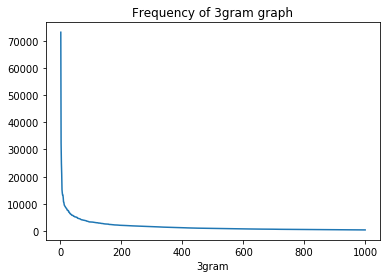

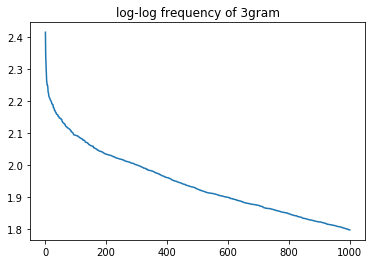

Graphs on Sentence Model


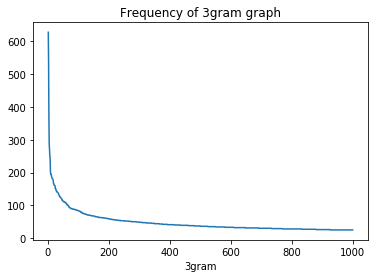

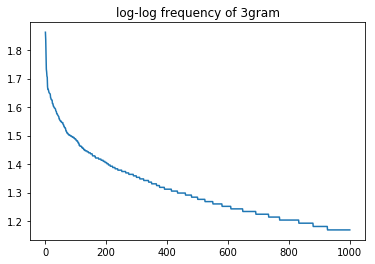

In [13]:
def insight(n):
    print("Graphs on Word Model")
    plot(char_ngrams[n], str(n) + 'gram')
    print("Graphs on Sentence Model")
    plot(sent_ngrams[n], str(n) + 'gram')
    

insight(3)

# Zipf's law

[(',', 69158),
 ('the', 46927),
 ('.', 40850),
 ('and', 27249),
 ('of', 25840),
 ('to', 25387),
 ('"', 23497),
 ('a', 18097),
 ('i', 14157),
 ('in', 13180)]


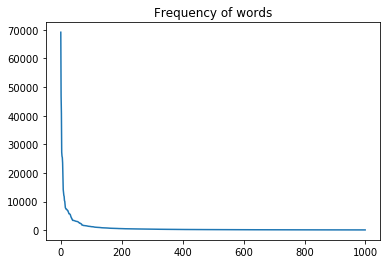

In [14]:
pp.pprint(word_token_counter.most_common(10))

y = [b for a, b in word_token_counter.most_common(1000)]
x = range(len(y))

plt.plot(x, y)
plt.title('Frequency of words')
plt.show()

# Probability Calculations

In [15]:
def normalize_dict(dict1, dict2={}):
    if not bool(dict2):
        print("Normalizing Unigrams")
        make_dict = {}
        total = sum(dict1.values())
        for key in dict1:
            make_dict[key] = dict1[key]/total
        return make_dict
    else:
        print("Normalizing Multigrams")
        make_dict = {}
        for key in dict1:
            make_dict[key] = dict1[key] / dict2[key[:-1]]
        return make_dict

# Laplace Smoothing

In [16]:
def laplace(gram, ngrams):
    l = len(gram)
    V = len(ngrams[l-1].keys())
    lap_prob = (ngrams[l][gram] + 1) / (ngrams[l - 1][gram[:-1]] + V)
    return lap_prob


In [48]:
laplace_val = laplace(('the', 'day'), sent_ngrams)

print(laplace_val)


0.0019368930038325756
0.001048532055122828


# Good Turing

In [39]:
def N(language_model, c, l):
    arr = []
    for k, v in language_model[l].items():
        if v == c:
            arr.append(k)
    return len(arr)

def get_count_gt(language_model, token):
    l = len(token)
    if token not in language_model[l].keys():
        return N(language_model, 1, l) / sum(language_model[l].values())
    else:
        count = language_model[l][token]
        max_freq = language_model[l].most_common(1)[0][1]
        c1 = count + 1
        while c1 < max_freq:
            if N(language_model, c1, l) != 0: # if the count of 
                if N(language_model, c1, l) == N(language_model, count, l):
                    return count
                return c1 * N(language_model, c1, l) / N(language_model, count, l)
            c1 += 1
        return count

def get_prob_gt(language_model, token):
    l = len(token)
    f = get_count_gt(language_model, token[:-1]) + len(language_model[l-1].keys())
    val = (get_count_gt(language_model, token) + 1) / f
    return val

In [41]:
print(get_prob_gt(sent_ngrams, ('of', 'the')))

0.1173490108104972


# Backoff

In [43]:
def helper_func(model, token, factor=0.4):
    token = tuple(token)
    count = lambda token : model[len(token)][token] if token in model[len(token)].keys() else 0
    if len(token) == 1:
        return count(token) / sum(model[1].values())
    if count(token) > 0:
        return count(token) / count(token[:-1])
    return factor * helper_func(sent_ngrams, token[1:])


def backoff(group, n, factor=0.4, log=True):
    grams = generate_ngrams(group, n)
    probs = []
    for gram in grams:
        probs.append(helper_func(sent_ngrams, gram))
    if log:
        return np.log(probs).sum()
    return np.array(probs).prod()


In [44]:
x = backoff([('this', 'is', 'a', 'good', 'song')], 3, log=True)
x1 = backoff([('this', 'is', 'good', 'a', 'song')], 3, log=True)
print(x)
print(x1)




-16.479834072102612
-18.820233043542103


# Spelling Correction

In [35]:
alphabet = char_ngrams[1].keys()
words = sent_ngrams[1].keys()

def final_spell_score(word, n):
    score = score_grammaticality(word, char_ngrams[n])
    return score / len(word)

def known(test_words):
    k = set()
    for char in test_words:
        if (char,) in words:
            k.add(char)
    return k

def edits1(word):
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c[0] + R[1:]           for L, R in splits if R for c in alphabet]
    inserts    = [L + c[0] + R               for L, R in splits for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    return [e2 for e1 in edits1(word) for e2 in edits1(e1)]

def suggestions(word):
    return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
    
def correction(word, n):
    return max(suggestions(word), key=(lambda word : final_spell_score(word, n)))

test_words1 = 'bast'
print("SUGGESTIONS")
print(suggestions(test_words1))


SUGGESTIONS
{'beast', 'bats', 'last', 'bas', 'boast', 'east', 'vast', 'mast', 'hast', 'bat', 'fast', 'base', 'past', 'blast', 'bart', 'cast', 'bash', 'bust', 'best'}


# Grammaticality Test

In [25]:
def score_grammaticality(tokens, language_model):
    prob = 0
    tokens_for_test = generate_ngrams([tokens], 2)
    for token in tokens_for_test:
        prob = prob + np.log(laplace(token, sent_ngrams))
    return prob

In [26]:
a = score_grammaticality(('the', 'sky', 'is', 'blue'), sent_ngrams)
a1 = score_grammaticality(('the', 'is', 'blue', 'sky'), sent_ngrams)
print(a, a1)
a2 = score_grammaticality(('I', 'am', 'a', 'boy'), sent_ngrams)
a3 = score_grammaticality(('I', 'a', 'boy', 'am'), sent_ngrams)
print(a2, a3)

-28.350441828071347 -30.65368259556579
-23.756795500985014 -27.19182715460625


# Predict Next

In [27]:
def predict_next(model, sequence):
    prob = {}
    sequence = tuple(sequence)
    length = len(sequence)
    alphabet = model[1].keys()
    for letter in alphabet:
        gram = sequence + letter
        if gram in model[length + 1].keys() and sequence in model[length].keys():
            prob[gram] = laplace(gram, model)
    return sorted(prob.items(), key=lambda item: item[1], reverse=True)


In [28]:
predict_next(sent_ngrams, ['he', 'is'])

[(('he', 'is', 'a'), 0.00016637692182321944),
 (('he', 'is', 'not'), 8.149073721953605e-05),
 (('he', 'is', 'the'), 6.451350029879937e-05),
 (('he', 'is', 'to'), 6.451350029879937e-05),
 (('he', 'is', 'in'), 5.432715814635736e-05),
 (('he', 'is', 'still'), 4.0745368609768025e-05),
 (('he', 'is', 'very'), 3.395447384147335e-05),
 (('he', 'is', 'an'), 3.055902645732602e-05),
 (('he', 'is', 'quite'), 3.055902645732602e-05),
 (('he', 'is', 'alive'), 3.055902645732602e-05),
 (('he', 'is', 'one'), 2.716357907317868e-05),
 (('he', 'is', 'as'), 2.3768131689031347e-05),
 (('he', 'is', 'but'), 2.3768131689031347e-05),
 (('he', 'is', 'so'), 2.0372684304884012e-05),
 (('he', 'is', 'at'), 2.0372684304884012e-05),
 (('he', 'is', 'now'), 2.0372684304884012e-05),
 (('he', 'is', 'of'), 1.6977236920736675e-05),
 (('he', 'is', 'coming'), 1.6977236920736675e-05),
 (('he', 'is', ';'), 1.6977236920736675e-05),
 (('he', 'is', 'too'), 1.6977236920736675e-05),
 (('he', 'is', 'no'), 1.6977236920736675e-05),
 ((